##**Reef Insight**: *A framework for reef community mapping  with clustering methods via remote sensing*

In [ ]:
!pip install rasterio

In [27]:
import numpy as np
import cv2
from osgeo import gdal, gdal_array
import rasterio
from matplotlib import pyplot as plt
from rasterio.plot import show

#Clustering packages
from sklearn import cluster
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN


mosaic_path = '/content/drive/MyDrive/unsw_remote_sensing/coral_atlas/mosaic.tif'
bathymetry_path = '/content/drive/MyDrive/unsw_remote_sensing/coral_atlas/bathymetry.tif'
   

###Section 0: Utility functions

In [28]:
def elbow_method_Kmeans(data, cluster_range):
  wcss=[]
  for i_cluster in cluster_range:
      kmeans=cluster.KMeans(n_clusters=i_cluster, init='k-means++',random_state=0)
      kmeans.fit(data)
      wcss.append(kmeans.inertia_)
  return wcss  
 

In [29]:
def bic_score_GMM(data,cluster_range, covariance_type):
    
  gmm_models=[GMM(n,covariance_type=covariance_type).fit(data) for n in cluster_range]
  bic_score=[i_model.bic(data) for i_model in gmm_models]
  return bic_score

In [30]:
def show_image(image):
  plt.figure(figsize=(12,12))
  plt.imshow(image) 
  plt.axis('off')
  plt.show()

In [31]:
def show_plot(x,y,x_label,y_label,title):
  plt.plot(x,y)
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.show()

In [32]:
def preprocess_for_clustering(mosaic):
  new_shape = (mosaic.shape[0] * mosaic.shape[1], mosaic.shape[2])
  mosaic_data = mosaic[:,:,:mosaic.shape[2]].reshape(new_shape)
  return mosaic_data

In [33]:
def show_cluster_output(clustering_labels,mosaic):
  clustering_labels_reshaped = clustering_labels.reshape(mosaic[:, :, 0].shape) #np.reshape(clustering_labels,mosaic.shape) 
  show_image(clustering_labels_reshaped)

###Section 1: Clustering methods

In [34]:
# 2.1 K-Means Clustering

def kmeans_mosaic(mosaic, no_of_clusters):
  mosaic_data = preprocess_for_clustering(mosaic)
  k_means = cluster.KMeans(n_clusters=no_of_clusters)  
  k_means.fit(mosaic_data)
  clustering_labels = k_means.labels_
  return clustering_labels 

In [35]:
# 2.2 Gaussian Mixture Model Clustering

def gmm_mosaic(mosaic, no_of_clusters,covariance_type):
  mosaic_data = preprocess_for_clustering(mosaic)
  gmm_model = GMM(n_components=no_of_clusters, covariance_type=covariance_type)
  gmm_model.fit(mosaic_data)
  clustering_labels=gmm_model.predict(mosaic_data)
  return clustering_labels 

In [36]:
# 2.3 Agglomerative Clustering

from scipy.ndimage.filters import gaussian_filter
from skimage.transform import rescale
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.utils.fixes import parse_version

def hac_mosaic(mosaic, no_of_clusters):

  rescale_params = {"anti_aliasing": False, "multichannel": False}
  # Resize it to 20% of the original size 
  # Applying a Gaussian filter for smoothing prior to down-scaling

  smoothened_mosaic = gaussian_filter(mosaic, sigma=2)
  rescaled_mosaic = rescale(smoothened_mosaic, 0.2, mode="reflect", **rescale_params)  
  connectivity = grid_to_graph(*rescaled_mosaic.shape)

  mosaic_data = preprocess_for_clustering(rescaled_mosaic)
  ward = AgglomerativeClustering(n_clusters=no_of_clusters, linkage="ward", connectivity=connectivity)
  ward.fit(mosaic_data)
  clustering_labels = ward.labels_
  return (clustering_labels,rescaled_mosaic)

In [37]:
# 2.4 DBSCAN clustering

def dbscan_mosaic(mosaic, epsilon, min_samples):

  index=np.indices(mosaic.shape[0:2])
  indices = np.dstack(np.indices(mosaic.shape[:2]))
  xy_and_colors = np.concatenate((mosaic, indices), axis=-1)
  mosaic_data=preprocess_for_clustering(xy_and_colors)
  
  dbscan_model = DBSCAN(eps=epsilon, min_samples=min_samples, metric = 'euclidean',algorithm ='auto')
  dbscan_model.fit(mosaic_data)
  clustering_labels = dbscan_model.labels_
  return clustering_labels


###Section 2: Loading the remote sensing data

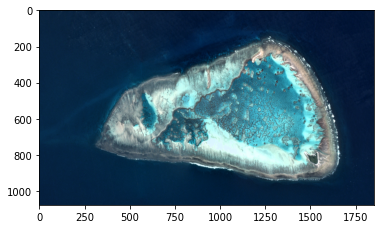

In [38]:
# Loading the reef-mosaic as RGB 

reef_mosaic_benthic = cv2.imread(mosaic_path)
reef_mosaic_benthic = cv2.cvtColor(reef_mosaic_benthic, cv2.COLOR_BGR2RGB)
plt.imshow(reef_mosaic_benthic)

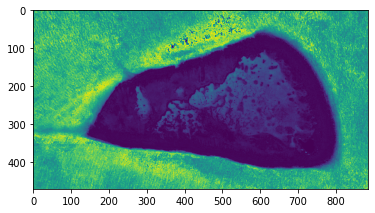

In [39]:
# Loading the bathymetry data

bathymetry_raster = rasterio.open(bathymetry_path)
bathymetry_raster_visual= bathymetry_raster.read([1])
show(bathymetry_raster_visual)
bathymetry_raster = bathymetry_raster_visual.reshape(bathymetry_raster_visual.shape[1],bathymetry_raster_visual.shape[2],bathymetry_raster_visual.shape[0])
bathymetry_raster = np.uint16(bathymetry_raster)

In [40]:
# Concatenting bathymetric information with the reef mosaic for geomorphic mapping

reef_mosaic_geomorphic=cv2.resize(reef_mosaic_benthic, (885,472))
reef_mosaic_geomorphic=np.concatenate((reef_mosaic_geomorphic,bathymetry_raster), axis=2)

###Section 3: Benthic maps  
number_of_cluster = 4

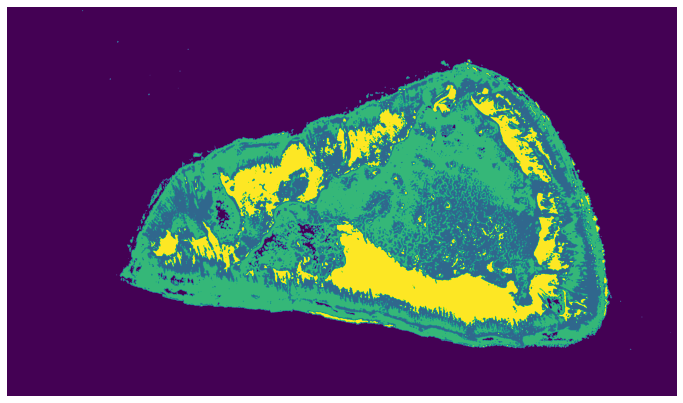

In [41]:
#3.1 Kmeans Result

kmeans_labels = kmeans_mosaic(reef_mosaic_benthic,4)
show_cluster_output(kmeans_labels,reef_mosaic_benthic)

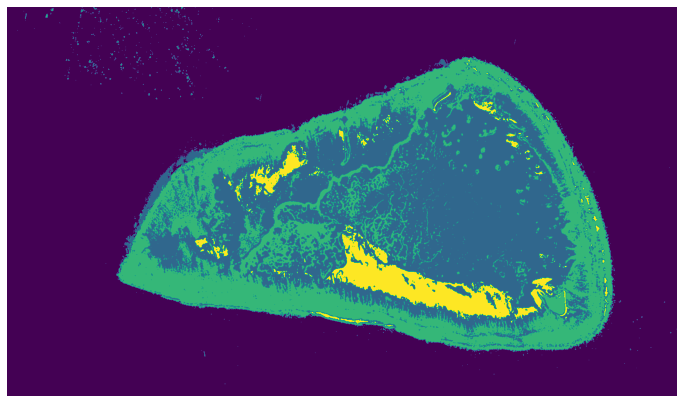

In [47]:
#3.1 Gaussian mixture model clustering result

gmm_labels_benthic = gmm_mosaic(reef_mosaic_benthic,4,'full')
show_cluster_output(gmm_labels_benthic,reef_mosaic_benthic)

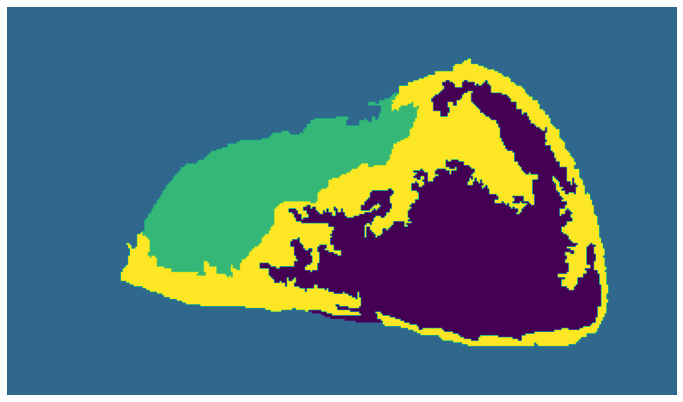

In [43]:
# 3.3 Hierarchichal agglomerative clustering result

hac_labels,mosaic_hac = hac_mosaic(reef_mosaic_benthic,4)
show_cluster_output(hac_labels,mosaic_hac)

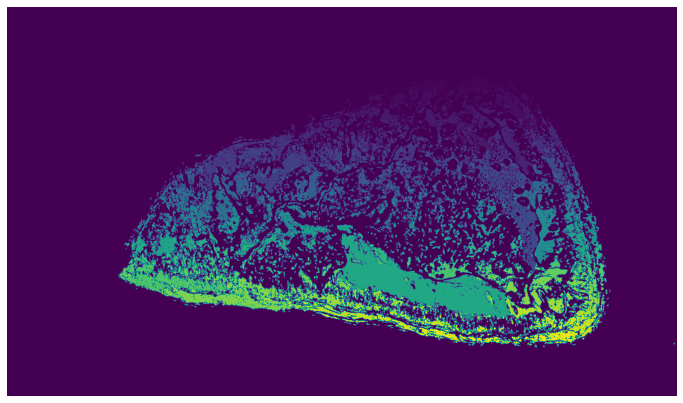

In [44]:
# 3.4 DBSCAN clustering result

dbscan_labels = dbscan_mosaic(reef_mosaic_benthic,5,9)
show_cluster_output(dbscan_labels,reef_mosaic_benthic)

###Section 4: Geomorphic maps  
number_of_cluster = 7

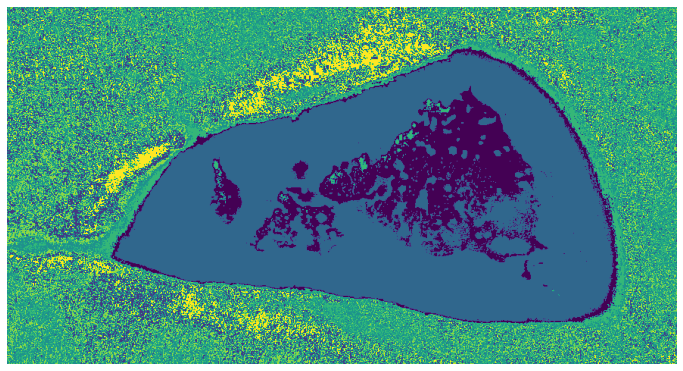

In [45]:
#3.1 Kmeans Result

kmeans_labels = kmeans_mosaic(reef_mosaic_geomorphic,7)
show_cluster_output(kmeans_labels,reef_mosaic_geomorphic)

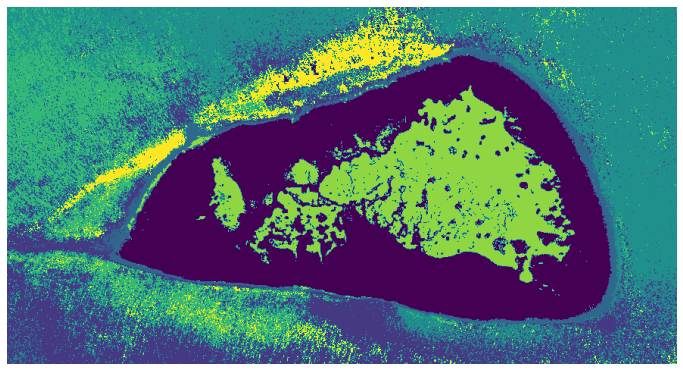

In [48]:
#3.1 Gaussian mixture model clustering result

gmm_labels_geomorphic = gmm_mosaic(reef_mosaic_geomorphic,7,'full')
show_cluster_output(gmm_labels_geomorphic,reef_mosaic_geomorphic)

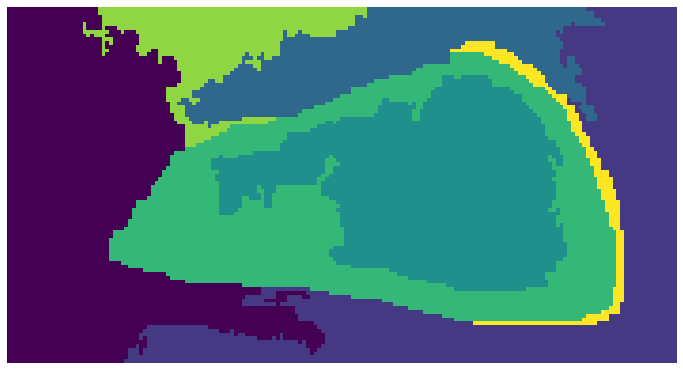

In [49]:
# 3.3 Hierarchichal agglomerative clustering result

hac_labels,mosaic_hac = hac_mosaic(reef_mosaic_geomorphic,7)
show_cluster_output(hac_labels,mosaic_hac)

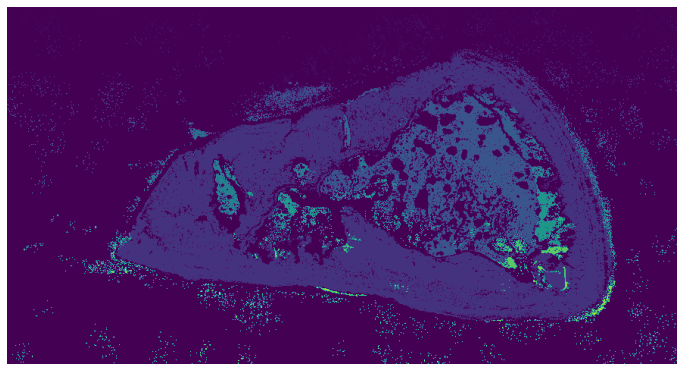

In [50]:
# 3.4 DBSCAN clustering result

dbscan_labels = dbscan_mosaic(reef_mosaic_geomorphic,17,15)
show_cluster_output(dbscan_labels,reef_mosaic_geomorphic)

### Section 5: Visual comparision with existing maps 
Gaussian Mixture model example


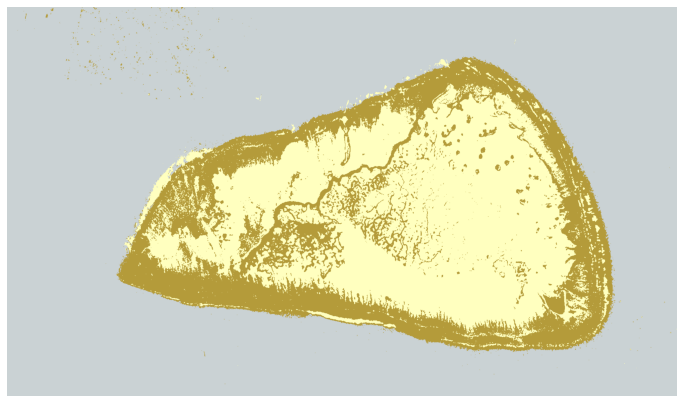

In [54]:
# 1. Benthic Map

label_to_color = {
    0: [202, 210, 212],  # sea - gray
    1: [255, 255, 191],  # sand - light yellow
    2: [180, 155, 58],  # rock - brown
    3: [255, 255, 191],  #

}
labels = {0:'ocean',1:'sand',2:'rock/rubble',3:'misc'}

height, width,_ = reef_mosaic_benthic.shape
gmm_labels_benthic_reshaped = gmm_labels_benthic.reshape(reef_mosaic_benthic[:, :, 0].shape)
refined_gmm_benthic_map = np.zeros((height, width, 3), dtype=np.uint8)

for gray, rgb in label_to_color.items():
    refined_gmm_benthic_map[gmm_labels_benthic_reshaped == gray, :] = rgb

# Visualising
show_image(refined_gmm_benthic_map)


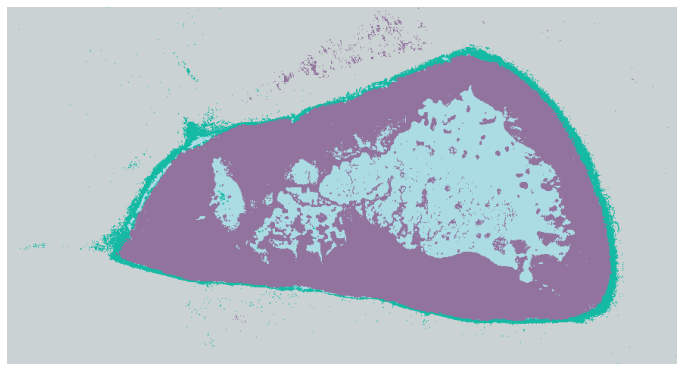

In [63]:
#2. Geomorphic Map
label_to_color = {
    
    0: [146,115,157],  #  purple [146, 115, 157] - reef flat
    1: [202,210,212],  #  ocean [202, 210, 212] - ocean
    2: [20,186,164],  
    3: [202,210,212],  #  green [20, 186, 164]   - reef slope 
    4: [202,210,212],
    5: [171,219,227],  #  light blue [171,219,227] - plateau/lagoon    
    6: [202,210,212],  

}

height, width,_ = reef_mosaic_geomorphic.shape
gmm_labels_geomorphic_reshaped = gmm_labels_geomorphic.reshape(reef_mosaic_geomorphic[:, :, 0].shape)
refined_gmm_geomorphic_map = np.zeros((height, width, 3), dtype=np.uint8)

for gray, rgb in label_to_color.items():
    refined_gmm_geomorphic_map[gmm_labels_geomorphic_reshaped == gray, :] = rgb

# Visualising
show_image(refined_gmm_geomorphic_map)

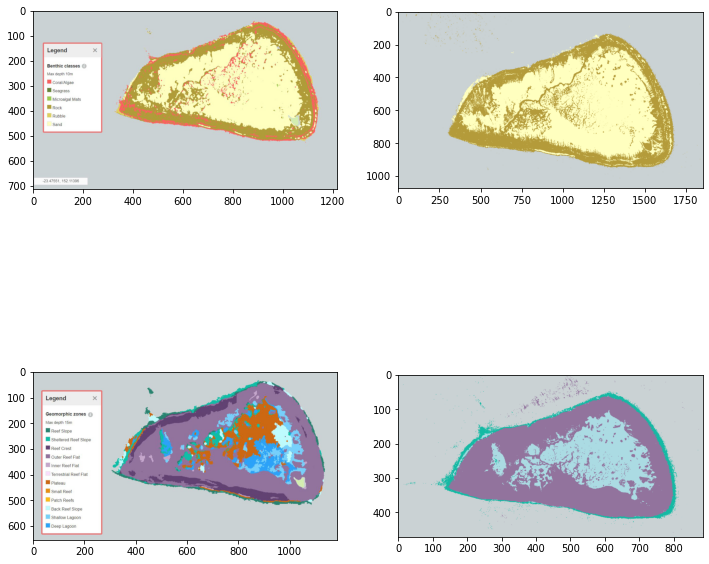

In [72]:
import imageio as iio
allen_coral_atlas_benthic_map = iio.imread('/content/drive/MyDrive/unsw_remote_sensing/benthic_map_ACA_legend.JPG')
allen_coral_atlas_geomorphic_map = iio.imread('/content/drive/MyDrive/unsw_remote_sensing/geomorphic_map_ACA_legend.JPG')

f, axarr = plt.subplots(nrows=2, ncols=2,figsize=(12,12))

axarr[0,0].imshow(allen_coral_atlas_benthic_map)
axarr[0,1].imshow(refined_gmm_benthic_map)
axarr[1,0].imshow(allen_coral_atlas_geomorphic_map)
axarr[1,1].imshow(refined_gmm_geomorphic_map)